**В проекте решалась задача идентификации пользователя в интернете по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).**

**Использовались данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей. В данном случае рассматривалась бинарная классификация: 1 - пользователь Элис, 0 - остальные пользователи.**



In [23]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [2]:
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\wild-moray\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['hstack', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [3]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\capstone_user_identification'

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [6]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [8]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно. В качестве метрики будет использоваться roc-auc score**

In [7]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [8]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [9]:
train_sites=train_test_df_sites.iloc[:train_df.shape[0]]

**Если так подумать, то признаки site1, ..., site10 смысла не имеют как признаки в задаче классификации. А вот если воспользоваться идеей мешка слов из анализа текстов – это другое дело. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки  i  и столбца  j  будет стоять число  nij  – cколько раз сайт  j  встретился в сессии номер  i . Делать это будем с помощью разреженных матриц Scipy – csr_matrix.**

In [10]:
def sparse_matrix(X):
    indptr = [0]
    indices = []
    data = []
    for row in X:
        for i in row:
            if i!=0:
                indices.append(i)
                data.append(1)
        indptr.append(len(indices))
    return csr_matrix((data, indices, indptr), dtype=int)

In [11]:
train_test_sparse = sparse_matrix(train_test_df_sites.values)

**Создадим разреженные матрицы *X_train_sparse* и *X_test_sparse* , выделим в отдельный вектор *y* ответы на обучающей выборке.**

In [12]:
X_train_sparse = train_test_sparse[:train_df.shape[0],1:]
X_test_sparse = train_test_sparse[train_df.shape[0]:,1:]
y = train_df['target'].values

**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [17]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [13]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, 1:], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, 1:], y[train_share:]

**Попробуем использовать линейный классификатов, основанный на стохастическом градиентном спуске `sklearn.linear_model.SGDClassifier` с логистической функцией потерь. Обучим модель на выборке `(X_train, y_train)`.**

In [14]:
sgd_logit = SGDClassifier(loss='log',random_state=17,n_jobs=-1,learning_rate='optimal')
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=17, shuffle=True,
       tol=None, verbose=0, warm_start=False)

**Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*. А также посчитаем roc-auc**

In [15]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:,1]

In [16]:
roc_auc_1=roc_auc_score(y_score=logit_valid_pred_proba,y_true=y_valid)

In [17]:
print("ROC AUC на отложенной выборке равен "+str(round(roc_auc_1,3)))

ROC AUC на отложенной выборке равен 0.934


**Попробуем добавить новые признаки**

In [18]:
def new_features(X):
    time=['time%d' % i for i in range(1, 11)]
    sites=['site%d' % i for i in range(1, 11)]
    df = X[time]
    df_sites=X[sites]
    for col in df.columns:
        df[col]=pd.to_datetime(df[col])
    df['min'] = df.min(axis=1)
    df['max'] = df.max(axis=1)
    df['unique_sites']=[len(np.unique(row)) for row in df_sites.values]
    df['length_sec']=((df['max'] - df['min']) / np.timedelta64(1, 's'))
    df.fillna(0, inplace=True)
    df['day_of_week']=df['time1'].apply(lambda x: x.weekday())
    df['start_hour']=df['time1'].apply(lambda x: x.hour)
    df['morning'] = ((df['start_hour'] >= 7) & (df['start_hour'] <= 11)).astype('int')
    df['day'] = ((df['start_hour'] >= 12) & (df['start_hour'] <= 18)).astype('int')
    df['evening'] = ((df['start_hour'] >= 19) & (df['start_hour'] <= 23)).astype('int')
    df['night'] = ((df['start_hour'] >= 0) & (df['start_hour'] <= 6)).astype('int')
    df['yyyymm'] = df['time1'].apply(lambda x: 100 * x.year + x.month).astype(np.int32)
    df['time_of_day']=list(map(lambda x: 1 if (x>=7 and x<=11) else 2 if (x>=12 and x<=18) else 3 if (x>=19 and x<=23) else 0,
         df['start_hour'].astype('int')))
    return df

In [19]:
df_features=new_features(train_test_df)

In [20]:
df_features_train=df_features.iloc[:train_df.shape[0]]
df_features_test=df_features.iloc[train_df.shape[0]:]

**Построим распределение числа уникальных сайтов и проверим распределение на нормальность**

Text(0.5,1,'Распределение числа уникальных сайтов')

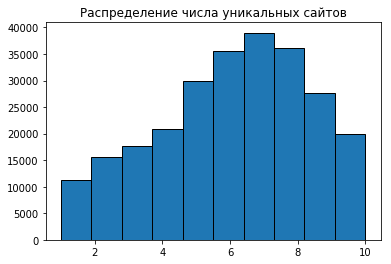

In [36]:
df_features_train['unique_sites'].hist(edgecolor = 'black',grid=False)
plt.title('Распределение числа уникальных сайтов')

In [55]:
from scipy import stats
rasp=pd.Series(df_features_train['unique_sites']).value_counts()
stats.shapiro(rasp.values)

(0.9381911158561707, 0.5330668687820435)

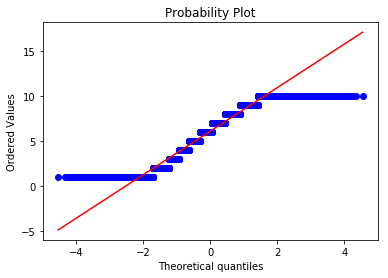

In [52]:
from scipy import stats
_ = stats.probplot(df_features_train['unique_sites'].values, dist="norm", plot=plt)

Исходя из критерия Шапиро-Уилка и qq-plot видно, что распределение не является нормальным.

**Построим распределение частоты сайтов, которые были посещены не менее 1000 раз.**

Text(0.5,1,'Распределение частоты посещения сайтов')

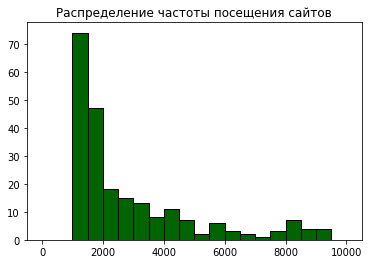

In [43]:
wordcount={}
for row in train_sites.values:
    for word in row:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] = wordcount[word]+1
freqs=np.array([wordcount[key] for key in wordcount.keys()])
plt.hist(freqs[freqs>1000],edgecolor = 'black',bins=20,range=(0,10000),color='darkgreen')
plt.title('Распределение частоты посещения сайтов')

**Построим 95% доверительный интервал для средней частоты появления сайта в выборке (во всей, уже не только для тех сайтов, что были посещены как минимум 1000 раз) на основе bootstrap.**

In [44]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, 
                 [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [45]:
def get_bootstrap_samples(data, n_samples, random_seed=17):
    np.random.seed(random_seed)
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [46]:
from more_itertools import unique_everseen
freqs=list(unique_everseen(freqs))
samples=get_bootstrap_samples(np.array(freqs),len(freqs))
means=[]
for sample in samples:
    means.append(sample.mean())
interval=stat_intervals(means,0.05)
print("95% доверительный интервал для средней частоты",'{} {}'.format(round(interval[0], 3),
                                   round(interval[1], 3)))

95% доверительный интервал для средней частоты 1830.643 2948.061


In [47]:
df_features_train['target']=y.reshape(-1,1)

**Построим распределения признаков, чтобы визуально выявить те, которые наилучшим образом разделяют Элис и остальных пользователей**

[Text(0,0,'Утро'), Text(0,0,'День'), Text(0,0,'Вечер'), Text(0,0,'Ночь')]

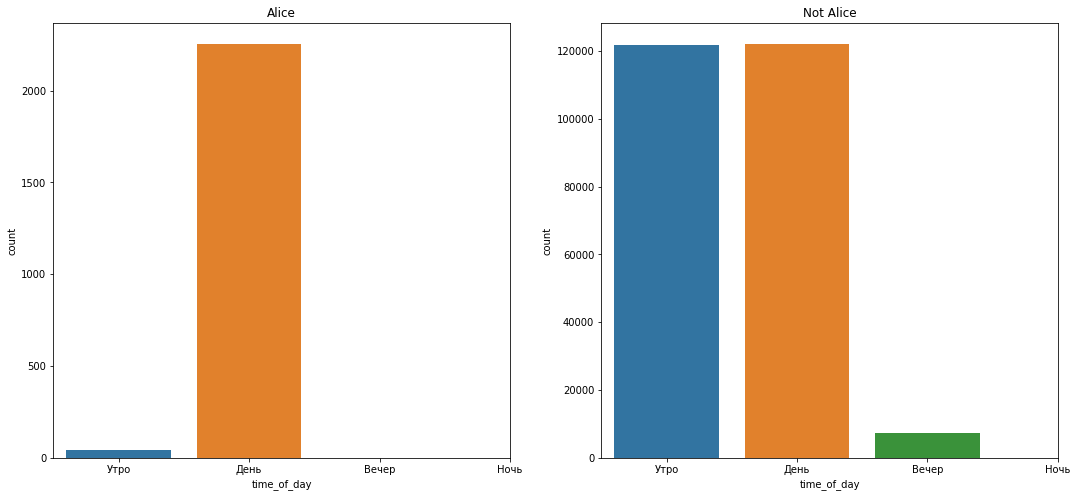

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
time_of_day=['Утро','День','Вечер','Ночь']
sns.countplot(x="time_of_day", data=df_features_train[df_features_train['target']==1], ax=axes[0]) 
sns.countplot(x="time_of_day", data=df_features_train[df_features_train['target']==0], ax=axes[1])
axes[0].set_title('Alice')
axes[1].set_title('Not Alice')
axes[0].set_xticks(range(len(time_of_day)))
axes[0].set_xticklabels(time_of_day)
axes[1].set_xticks(range(len(time_of_day)))
axes[1].set_xticklabels(time_of_day)

Распределение времени дня также может помочь разделить выборки: Элис чаще всего онлайн днем, почти не бывает утром и вообще отсутствует вечером, в то время, как остальные пользователи проявляют одинаковую активность утром-днем и есть нечастые вечерние сессии.

[Text(0,0,'Пн'),
 Text(0,0,'Вт'),
 Text(0,0,'Ср'),
 Text(0,0,'Чт'),
 Text(0,0,'Пт'),
 Text(0,0,'Сб'),
 Text(0,0,'Вс')]

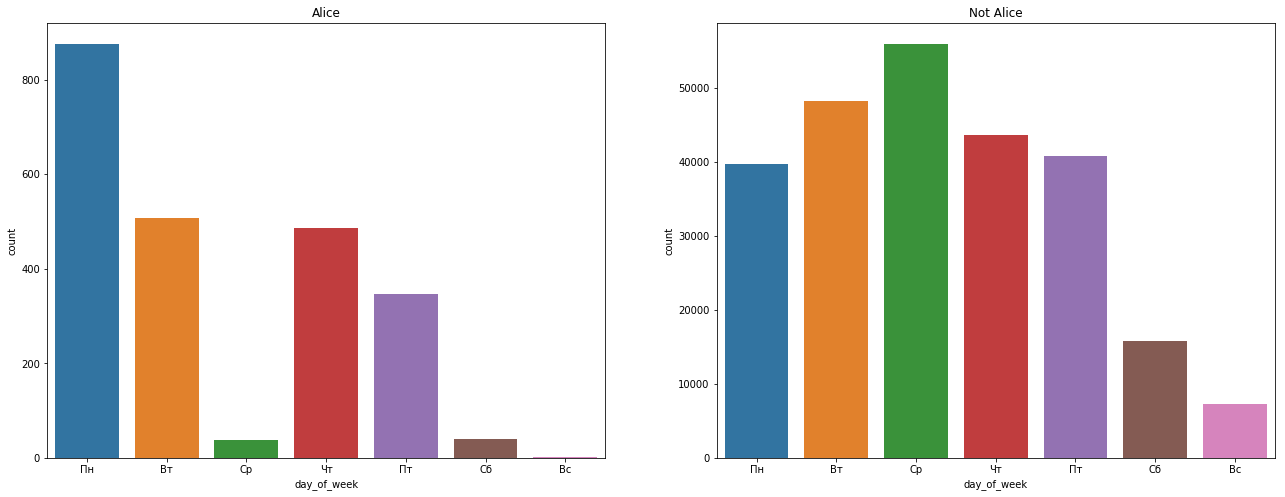

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
days=['Пн','Вт','Ср','Чт','Пт','Сб', 'Вс']
sns.countplot(x="day_of_week", data=df_features_train[df_features_train['target']==1], ax=axes[0]) 
sns.countplot(x="day_of_week", data=df_features_train[df_features_train['target']==0], ax=axes[1]) 
axes[0].set_title('Alice')
axes[1].set_title('Not Alice')
axes[0].set_xticks(range(len(days)))
axes[0].set_xticklabels(days)
axes[1].set_xticks(range(len(days)))
axes[1].set_xticklabels(days)

Из распределения дня недели начала сессии видно, что Элис чаще всего бывает в сети в понедельник, реже во вторник, четверг и пятницу, в то время как остальные пользователи чаще бывают в среду. Распределение признака значительно отличается, следовательно он может быть полезен при классификации.

Text(0.5,1,'Not Alice')

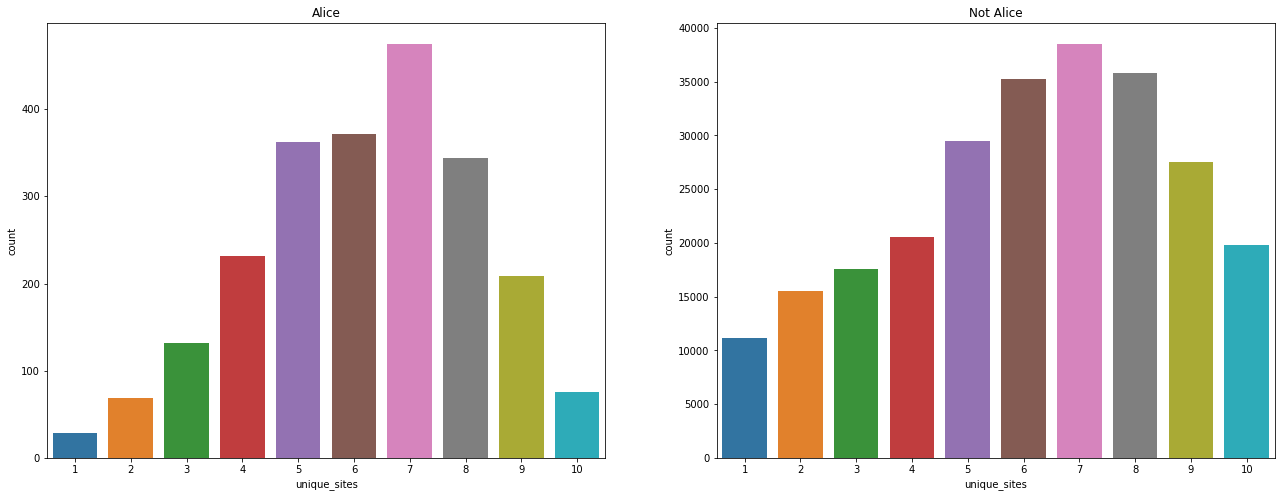

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
sns.countplot(x="unique_sites", data=df_features_train[df_features_train['target']==1], ax=axes[0]) 
sns.countplot(x="unique_sites", data=df_features_train[df_features_train['target']==0], ax=axes[1])
axes[0].set_title('Alice')
axes[1].set_title('Not Alice')

Распределение количества уникальных сайтов в сессии хоть и имеет схожий вид, напоминающий по форме нормальное распределение, однако у распределения Элис более легкие хвосты, в то время как распределение остальных пользователей скошено влево.

Text(0.5,1,'Not Alice')

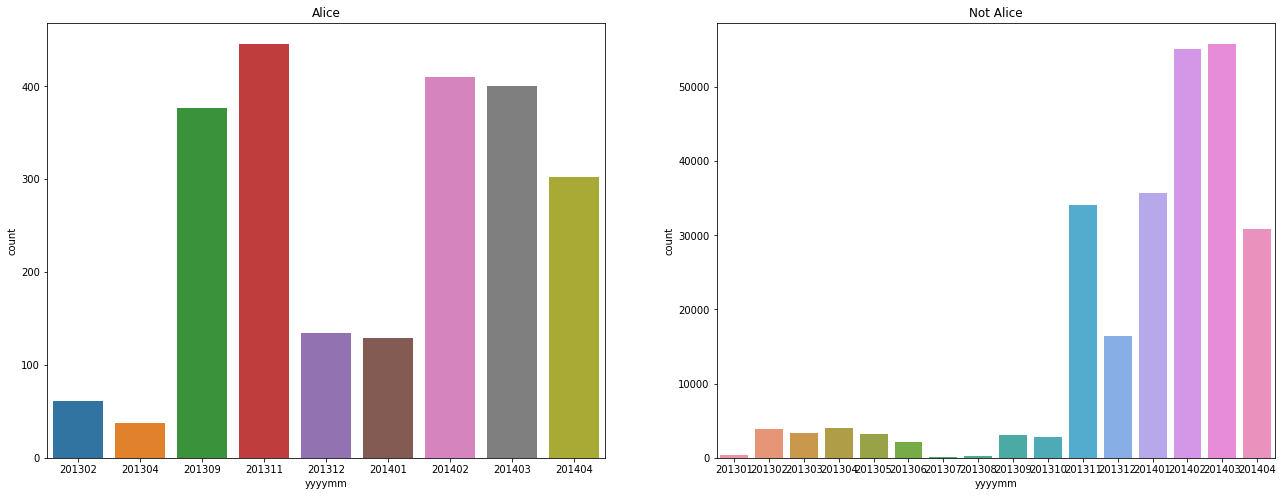

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,8))
sns.countplot(x="yyyymm", data=df_features_train[df_features_train['target']==1], ax=axes[0]) 
sns.countplot(x="yyyymm", data=df_features_train[df_features_train['target']==0], ax=axes[1])
axes[0].set_title('Alice')
axes[1].set_title('Not Alice')

Неожиданно неплохо отделяющим выборки признаком стал  признак год-месяц начала сессии. У Элис самым активным был ноябрь 2013, в то время как у других пользователей этот месяц был менее популярен для посещения интернета.

Для категориального признака day_of_week сделаем one-hot кодирование и масштабируем признаки yyyymm и length

In [21]:
X_cat=df_features['day_of_week'].values
length=StandardScaler().fit_transform(df_features['length_sec'].values.reshape(-1,1))
yyyymm=StandardScaler().fit_transform(df_features['yyyymm'].values.reshape(-1,1))
encoder=OneHotEncoder(sparse=False)
encod_all=encoder.fit_transform(X_cat.reshape(-1,1))
df_features.drop(['time1','time2','time3','time4','time5','time6','time7',
        'time8','time9','time10','day_of_week','length_sec','yyyymm'],inplace=True,axis=1)

C:\Users\wild-moray\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\wild-moray\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Соединим новые признаки и разреженную матрицу, созданную ранее. Далее разделим выборку на обучающую и тестовую. Также для настройки параметров и проверки качества алгоритмов разделим обучающую выборку на обучающую и отложенную в пропорции 70/30

In [22]:
df_features.drop(['min','max','unique_sites','start_hour','time_of_day'],inplace=True,axis=1)

In [24]:
X_all=hstack([train_test_sparse,df_features.values,encod_all,yyyymm]).tocsr()

In [25]:
train=X_all[:train_df.shape[0]]
test=X_all[train_df.shape[0]:]
train_X, test_X, train_y, test_y = train_test_split(train, y, train_size=0.7,shuffle=True)

Протестируем ранее использовавшийся `sklearn.linear_model.SGDClassifier` с логистической функцией потерь

In [62]:
sgd_logit = SGDClassifier(loss='log',random_state=17,n_jobs=-1,learning_rate='optimal')
sgd_logit.fit(train_X,train_y)
roc_auc_score(test_y, sgd_logit.predict_proba(test_X)[:,1])

0.9653095166701944

Качество улучшилось, попробуем также протестировать ансамблиевый  `xgb.XGBClassifier`

In [63]:
xgb_clf=xgb.XGBClassifier()
xgb_clf.fit(train_X,train_y)
roc_auc_score(test_y, xgb_clf.predict_proba(test_X)[:,1])

0.9608074539624816

Протестируем также 

In [64]:
logit=LogisticRegression(n_jobs=-1)
logit.fit(train_X,train_y)
roc_auc_score(test_y, logit.predict_proba(test_X)[:,1])

0.9834815075769817

**Попробуем подобрать параметры для градиентного бустинга и для линейного классификатора**

In [26]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [30]:
#Функция для рисования кривых валидации
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Для градиентного бустинга подберем сначала количество базовых моделей

In [32]:
n_est = np.linspace(1000,3000,5).astype('int')
xgb_clf=xgb.XGBClassifier()

xgb_grid_search = GridSearchCV(estimator=xgb_clf, param_grid={'n_estimators': n_est},
                                  scoring='roc_auc',cv=skf, n_jobs=1, verbose=1)

In [33]:
xgb_grid_search.fit(train_X,train_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 99.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([1000, 1500, 2000, 2500, 3000])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

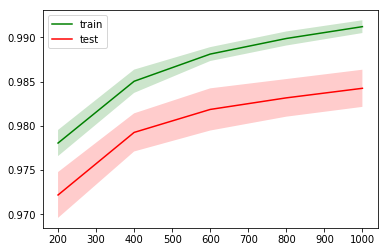

In [31]:
plot_validation_curves(n_est,xgb_grid_search.cv_results_)

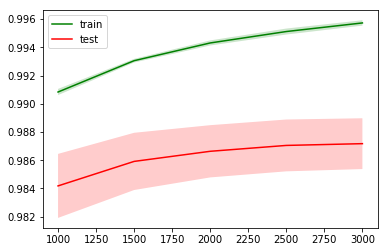

In [35]:
plot_validation_curves(n_est,xgb_grid_search.cv_results_)

По кривым валидации видим, что в районе 3000 качество на тесте перестает расти

In [54]:
n_estim_best=xgb_grid_search.best_params_['n_estimators']

Далее подберем параметр обучения для заданного числа базовых моделей (одновременно подбор осуществляется очень долго)

In [37]:
l=np.linspace(0.1,0.5,10)
xgb_clf1=xgb.XGBClassifier(n_estimators=3000)

xgb_grid_search1 = GridSearchCV(estimator=xgb_clf1, param_grid={'learning_rate': l},
                                  scoring='roc_auc',cv=skf, n_jobs=1, verbose=1)

In [38]:
xgb_grid_search1.fit(train_X,train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 309.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': array([0.1    , 0.14444, 0.18889, 0.23333, 0.27778, 0.32222, 0.36667,
       0.41111, 0.45556, 0.5    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [55]:
l_best=xgb_grid_search1.best_params_['learning_rate']

Для линейного классификатора подберем параметр регуляризации alpha

In [46]:
alpha=np.linspace(0.00001,0.0001,50)
#penalty = ['l1','l2']
sgd_logit = SGDClassifier(loss='log',n_jobs=-1,learning_rate='optimal',penalty='l2')

sgd_grid_search1 = GridSearchCV(estimator=sgd_logit, param_grid={'alpha': alpha},
                                  scoring='roc_auc',cv=skf, n_jobs=1, verbose=1)

In [47]:
sgd_grid_search1.fit(train_X,train_y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   45.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([1.00000e-05, 1.18367e-05, 1.36735e-05, 1.55102e-05, 1.73469e-05,
       1.91837e-05, 2.10204e-05, 2.28571e-05, 2.46939e-05, 2.65306e-05,
       2.83673e-05, 3.02041e-05, 3.20408e-05, 3.38776e-05, 3.57143e-05,
       3.75510e-05, 3.93878e-05, 4.12245e-05, 4.30612e-05, 4.48... 8.89796e-05, 9.08163e-05,
       9.26531e-05, 9.44898e-05, 9.63265e-05, 9.81633e-05, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', 

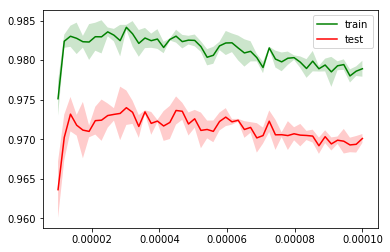

In [49]:
plot_validation_curves(alpha,sgd_grid_search1.cv_results_)

На кривой валидации видно, что параметр находится где-то в районе 0.00003

In [56]:
alpha_best=sgd_grid_search1.best_params_['alpha']

**Для получения лучшего результата попробуем сделать стекинг логистической регрессии, линейного классификатора и градиентного бустинга**

**Идея и реализация стекинга была взята из [статьи А.Дьяконова](https://dyakonov.org/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)**

In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DjStacking(BaseEstimator, ClassifierMixin):  

    def __init__(self, models, ens_model):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        """
        self.models = models
        self.ens_model = ens_model
        self.n = len(models)
        self.valid = None
        
    def fit(self, X, y=None, p=0.25, cv=2, err=0, random_state=None):
        """
        Обучение стекинга
        p - в каком отношении делить на обучение / тест
            если p = 0 - используем всё обучение!
        cv  (при p=0) - сколько фолдов использовать
        err (при p=0) - величина случайной добавки к метапризнакам
        random_state - инициализация генератора
            
        """
        if (p > 0): # делим на обучение и тест
            # разбиение на обучение моделей и метамодели
            train, valid, y_train, y_valid = train_test_split(X, y, test_size=p, random_state=random_state)
            
            # заполнение матрицы для обучения метамодели
            self.valid = np.zeros((valid.shape[0], self.n))
            for t, clf in enumerate(self.models):
                clf.fit(train, y_train)
                self.valid[:, t] = clf.predict_proba(valid)[:,1]
                
            # обучение метамодели
            self.ens_model.fit(self.valid, y_valid)
            
        else: # используем всё обучение
            
            # для регуляризации - берём случайные добавки
            self.valid = err*np.random.randn(X.shape[0], self.n)
            
            for t, clf in enumerate(self.models):
                # это oob-ответы алгоритмов
                self.valid[:, t] += cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba')[:,1]
                # но сам алгоритм надо настроить
                clf.fit(X, y)
            
            # обучение метамодели
            self.ens_model.fit(self.valid, y) 
            

        return self
    


    def predict(self, X, y=None):
        """
        Работа стэкинга
        """
        # заполение матрицы для мета-классификатора
        X_meta = np.zeros((X.shape[0], self.n))
        
        for t, clf in enumerate(self.models):
            X_meta[:, t] = clf.predict_proba(X)[:,1]
        a = self.ens_model.predict_proba(X_meta)[:,1]
        
        return (a)

In [57]:
xgb_clf=xgb.XGBClassifier(learning_rate=l_best,n_estimators=n_estim_best)
logit=LogisticRegression()
#sgd_logit= SGDClassifier(loss='log',n_jobs=-1,penalty='l2', alpha=3.368421052631579e-05)


models = [logit,xgb_clf] 
ens_model = SGDClassifier(loss='log',n_jobs=-1,penalty='l2', alpha=alpha_best)
s1 = DjStacking(models, ens_model)
s1.fit(train_X, train_y,p=0.25,cv=3,err=0)
a = s1.predict(test_X, train_y)
auc = roc_auc_score(test_y, a)
print (auc)

0.9887907294977124


In [58]:
s1.fit(train, y)

DjStacking(ens_model=SGDClassifier(alpha=3.020408163265306e-05, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
      models=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), XGBClassifier(base_score=0..., reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)])

На отложенной выборке довольно неплохой результат, загрузим посылку на Kaggle для проверки результата на тестовой выборке

Функция для записи результатов в файл

In [60]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [61]:
write_to_submission_file(s1.predict(test, y),'predicted_labels_.csv')

**Текущий результат на тестовой выборке roc_auc=0.95161**

**Для улучшения результата можно попробовать добавить и потестировать новые признаки, а также попробовать другие комбинации алгоритмов.**